#### First DL models 1D and 2D Convolution by machines then all machines

In [8]:
#Let's first import the module that we will need
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pywt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import metrics

import itertools

In [9]:
#Constant used throughout the notebook
PATH_TRAINING_DATASET = r"C:\Users\sylv_\Documents\audio for asd"

In [157]:
def build_dataframe(machine_str = 'valve'):
    #Get list of files in train and test directory
    path_train_folder = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\train"
    path_test_folder = PATH_TRAINING_DATASET  + "\\dev_" + machine_str + "\\" + machine_str + "\\test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "\\" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:])        #.split('.')[0]  --> want to keep the complete suffix
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder  + "\\" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:])     #.split('.')[0]  --> want to keep the complete suffix
        })
        
    return pd.DataFrame(list_dict_file)


def sound_from_file(filename, machine_str = 'valve', dataset = 'train'):
    df = build_dataframe(machine_str)
    path = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\" + dataset + "\\" + filename
    return df[df['filepath']==path].iloc[0]
    


df_fan = build_dataframe('fan')
df_valve = build_dataframe('valve')
df_bearing = build_dataframe('bearing')
df_slider = build_dataframe('slider')
df_car = build_dataframe('ToyCar')
df_train = build_dataframe('ToyTrain')
df_gearbox = build_dataframe('gearbox')

df_fan.info()
df_fan.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    3600 non-null   object
 1   filename    3600 non-null   object
 2   section     3600 non-null   int64 
 3   domain_env  3600 non-null   object
 4   dir         3600 non-null   object
 5   sound_type  3600 non-null   object
 6   id          3600 non-null   object
 7   suffix      3600 non-null   object
dtypes: int64(1), object(7)
memory usage: 225.1+ KB


,filepath,filename,section,domain_env,dir,sound_type,id,suffix
0,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0000_m-n_W.wav,0,source,train,normal,0000,m-n_W.wav
1,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0001_m-n_X.wav,0,source,train,normal,0001,m-n_X.wav
2,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0002_m-n_X.wav,0,source,train,normal,0002,m-n_X.wav
3,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0003_m-n_W.wav,0,source,train,normal,0003,m-n_W.wav
4,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0004_m-n_W.wav,0,source,train,normal,0004,m-n_W.wav
5,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0005_m-n_X.wav,0,source,train,normal,0005,m-n_X.wav
6,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0006_m-n_X.wav,0,source,train,normal,0006,m-n_X.wav
7,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0007_m-n_W.wav,0,source,train,normal,0007,m-n_W.wav
8,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0008_m-n_W.wav,0,source,train,normal,0008,m-n_W.wav
9,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0009_m-n_X.wav,0,source,train,normal,0009,m-n_X.wav


### Essai valve

In [46]:
df0 = df_valve # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=500).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)
target1= df_use0['sound_type']

target = target1.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

In [47]:
X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_selected["filepath"], target, test_size=0.2,
                                                              random_state=123)

In [48]:
Y_train = Y_train.values
Y_test = Y_test.values

In [49]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

def logMelSpectrogram(audio, fe, dt):
    # Spectrogramme
    stfts = np.abs(librosa.stft(audio,
                                n_fft=int(dt*fe),
                                hop_length=int(dt*fe),
                                center=True
                                )).T
    num_spectrogram_bins = stfts.shape[-1]
    # Filtre de MEL
    linear_to_mel_weight_matrix = librosa.filters.mel(
        sr=fe,
        n_fft=int(dt*fe) + 1,
        n_mels=num_spectrogram_bins,
    ).T

    # Application du filtre au spectrogramme
    mel_spectrograms = np.tensordot(
        stfts,
        linear_to_mel_weight_matrix,
        1
    )
    return np.log(mel_spectrograms + 1e-6)

def load_data(audio_path, dt=0.03):
    X_audio = []
    Y_audio=[]
    Z_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)

        # On applique la fonction logMelSpectrogram.
        #spectre_audio = logMelSpectrogram(data, fe, dt)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt), hop_length = int(fe*dt)))
        #X_audio.append(spectre_audio)
        Y_audio.append(spectre_ft)
        #coeff, freq = pywt.cwt(data,scales=np.arange(1,129), wavelet='morl')
        #Z_audio.append(coeff)
    return np.array(Y_audio)

# On obtient nos jeux d'entrainement et de test prêts pour la modélisation.


X_train = load_data(X_train_path)
X_test = load_data(X_test_path)

In [50]:
X_train.shape
#X_test.shape

(640, 241, 334)

In [51]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LeakyReLU, Flatten, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

num_classes = 2

model = Sequential()
# Partie 1
model.add(Conv1D(64, kernel_size=5, dilation_rate=2,
          input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 2
model.add(Conv1D(128, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 3
model.add(Conv1D(256, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())

# Classification
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
 


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 233, 64)           106944    
                                                                 
 dropout_16 (Dropout)        (None, 233, 64)           0         
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 233, 64)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 225, 128)          41088     
                                                                 
 dropout_17 (Dropout)        (None, 225, 128)          0         
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 225, 128)          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 217, 256)         

In [52]:
history = model.fit(X_train, Y_train, validation_split=0.2, verbose=1, batch_size=50, epochs=100)

Epoch 1/100
11/11 [==============================] - 2s 122ms/step - loss: 0.6718 - accuracy: 0.6016 - val_loss: 0.6227 - val_accuracy: 0.7031
Epoch 2/100
11/11 [==============================] - 1s 84ms/step - loss: 0.6781 - accuracy: 0.6055 - val_loss: 0.6584 - val_accuracy: 0.7031
Epoch 3/100
11/11 [==============================] - 1s 84ms/step - loss: 0.6734 - accuracy: 0.6055 - val_loss: 0.6518 - val_accuracy: 0.7031
Epoch 4/100
11/11 [==============================] - 1s 82ms/step - loss: 0.6668 - accuracy: 0.6055 - val_loss: 0.6752 - val_accuracy: 0.7109
Epoch 5/100
11/11 [==============================] - 1s 79ms/step - loss: 0.6784 - accuracy: 0.5859 - val_loss: 0.6101 - val_accuracy: 0.7031
Epoch 6/100
11/11 [==============================] - 1s 80ms/step - loss: 0.6796 - accuracy: 0.6055 - val_loss: 0.6315 - val_accuracy: 0.7031
Epoch 7/100
11/11 [==============================] - 1s 80ms/step - loss: 0.6567 - accuracy: 0.6074 - val_loss: 0.6561 - val_accuracy: 0.7031
Epoch

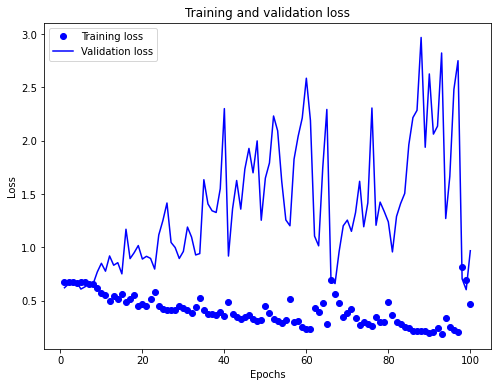

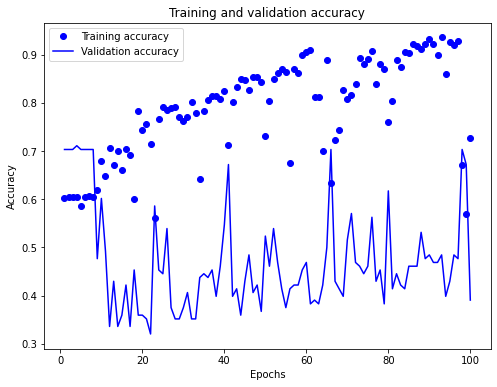

In [53]:
# Plot des courbes des loss d'entrainement et de validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)


5/5 [==============================] - 0s 15ms/step


In [55]:
print(metrics.classification_report(Y_test, test_pred_class))

              precision    recall  f1-score   support

           0       0.67      0.34      0.45       100
           1       0.39      0.72      0.51        60

    accuracy                           0.48       160
   macro avg       0.53      0.53      0.48       160
weighted avg       0.56      0.48      0.47       160



### Essai bearing

In [26]:
df0 = df_bearing # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=500).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)
target1= df_use0['sound_type']

target = target1.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])



In [27]:
X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_selected["filepath"], target, test_size=0.2,
                                                              random_state=123)

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)
X_train.shape
X_test.shape

(160, 401, 201)

In [28]:
num_classes = 2

model = Sequential()
# Partie 1
model.add(Conv1D(64, kernel_size=5, dilation_rate=2,
          input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 2
model.add(Conv1D(128, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 3
model.add(Conv1D(256, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())

# Classification
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_split=0.2, verbose=1, batch_size=32, epochs=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 393, 64)           64384     
                                                                 
 dropout_4 (Dropout)         (None, 393, 64)           0         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 393, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 385, 128)          41088     
                                                                 
 dropout_5 (Dropout)         (None, 385, 128)          0         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 385, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 377, 256)         

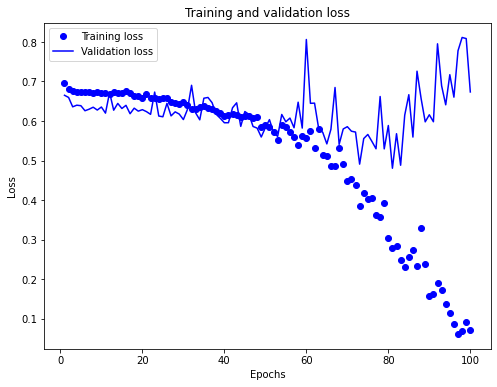

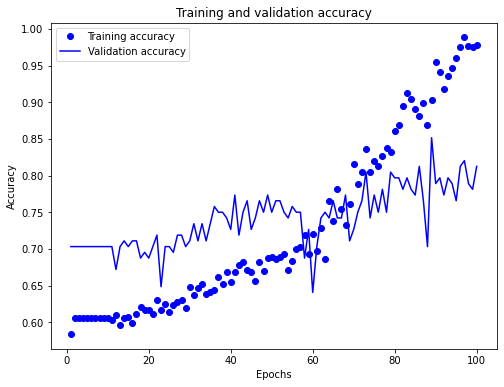

In [29]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
print(metrics.classification_report(Y_test, test_pred_class))

5/5 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       100
           1       0.86      0.50      0.63        60

    accuracy                           0.78       160
   macro avg       0.81      0.72      0.74       160
weighted avg       0.80      0.78      0.76       160



### Essai slider

In [31]:
df0 = df_slider # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=500).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)
target1= df_use0['sound_type']

target = target1.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_selected["filepath"], target, test_size=0.2,
                                                              random_state=123)

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)
X_train.shape
X_test.shape

(160, 401, 201)

In [32]:
num_classes = 2

model = Sequential()
# Partie 1
model.add(Conv1D(64, kernel_size=5, dilation_rate=2,
          input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 2
model.add(Conv1D(128, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 3
model.add(Conv1D(256, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())

# Classification
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_split=0.2, verbose=1, batch_size=32, epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 393, 64)           64384     
                                                                 
 dropout_8 (Dropout)         (None, 393, 64)           0         
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 393, 64)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 385, 128)          41088     
                                                                 
 dropout_9 (Dropout)         (None, 385, 128)          0         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 385, 128)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 377, 256)         

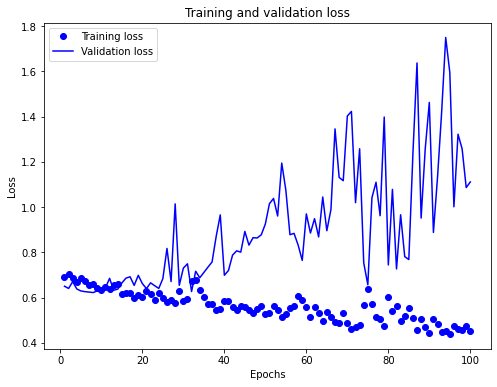

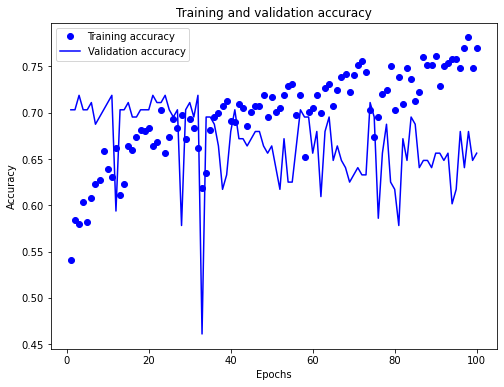

In [33]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
print(metrics.classification_report(Y_test, test_pred_class))

5/5 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       100
           1       0.56      0.17      0.26        60

    accuracy                           0.64       160
   macro avg       0.60      0.54      0.51       160
weighted avg       0.61      0.64      0.57       160



### Essai slider with other repartition

In [72]:
df0 = df_slider # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=300).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=150).reset_index()
df3=df0[df0['sound_type']=='anomaly'].sample(n=150).reset_index()
df4=df0[df0['sound_type']=='normal'].sample(n=300).reset_index()
df_use0= pd.concat([df2,df1]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)


df_targ= pd.concat([df3,df4]).reset_index()
df_targ= df_targ.drop('level_0', axis = 1)
df_selected1= df_targ.drop('index', axis = 1)

df_use0 = df_use0.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])
df_targ = df_targ.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])


X_train_path =df_use0["filepath"]
Y_train=df_use0['sound_type']                                                     


X_test_path = df_targ["filepath"]
Y_test =df_targ['sound_type']

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)


X_train.shape
X_test.shape

Y_train = Y_train.values
Y_test = Y_test.values

In [78]:
num_classes = 2

model = Sequential()
# Partie 1
model.add(Conv1D(64, kernel_size=5, dilation_rate=2,
          input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 2
model.add(Conv1D(128, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())

# Partie 3
model.add(Conv1D(256, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())

# Classification
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), verbose=1, batch_size=64, epochs=100)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 233, 64)           106944    
                                                                 
 dropout_48 (Dropout)        (None, 233, 64)           0         
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 233, 64)           0         
                                                                 
 conv1d_37 (Conv1D)          (None, 225, 128)          41088     
                                                                 
 dropout_49 (Dropout)        (None, 225, 128)          0         
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 225, 128)          0         
                                                                 
 conv1d_38 (Conv1D)          (None, 217, 256)        

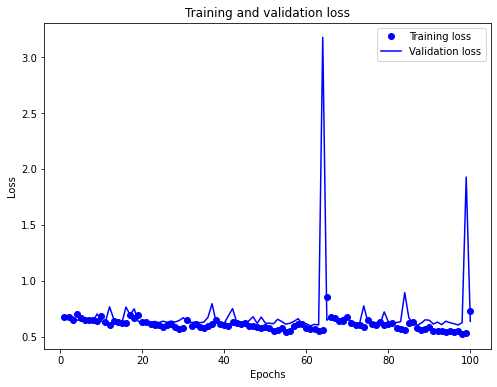

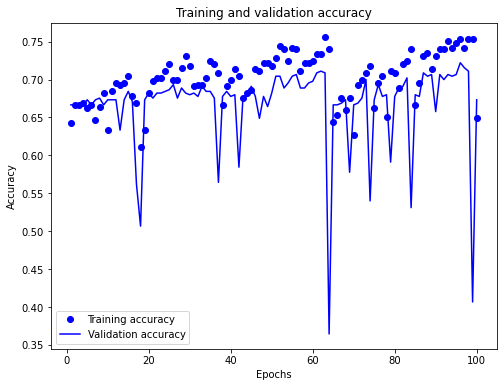

In [79]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [80]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
print(metrics.classification_report(Y_test, test_pred_class))

15/15 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       300
           1       0.53      0.18      0.27       150

    accuracy                           0.67       450
   macro avg       0.61      0.55      0.53       450
weighted avg       0.64      0.67      0.62       450



### With 2d convolution-slider

In [128]:
from PIL import Image

def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

def logMelSpectrogram(audio, fe, dt):
    # Spectrogramme
    stfts = np.abs(librosa.stft(audio,
                                n_fft=int(dt*fe),
                                hop_length=int(dt*fe),
                                center=True
                                )).T
    num_spectrogram_bins = stfts.shape[-1]
    # Filtre de MEL
    linear_to_mel_weight_matrix = librosa.filters.mel(
        sr=fe,
        n_fft=int(dt*fe) + 1,
        n_mels=num_spectrogram_bins,
    ).T

    # Application du filtre au spectrogramme
    mel_spectrograms = np.tensordot(
        stfts,
        linear_to_mel_weight_matrix,
        1
    )
    return np.log(mel_spectrograms + 1e-6)

def load_data(audio_path, dt=0.03):
    X_audio = []
    Y_audio=[]
    Z_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)

        # On applique la fonction logMelSpectrogram.
        #spectre_audio = logMelSpectrogram(data, fe, dt)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt), hop_length = int(fe*dt)))
        #X_audio.append(spectre_audio)
        Y_audio.append(spectre_ft)
        a_audio = np.expand_dims(Y_audio, 3)
        #coeff, freq = pywt.cwt(data,scales=np.arange(1,129), wavelet='morl')
        #Z_audio.append(coeff)
    return np.array(a_audio)
            


In [129]:
df0 = df_slider # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=500).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)
target1= df_use0['sound_type']

target = target1.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_selected["filepath"], target, test_size=0.2,
                                                              random_state=123)

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)
print(X_train.shape)
Y_train.shape

(640, 241, 334, 1)


(640,)

In [132]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#Compile


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), verbose=1, batch_size=32, epochs=6)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 239, 332, 32)      320       
                                                                 
 conv2d_22 (Conv2D)          (None, 237, 330, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 118, 165, 64)     0         
 2D)                                                             
                                                                 
 dropout_70 (Dropout)        (None, 118, 165, 64)      0         
                                                                 
 flatten_9 (Flatten)         (None, 1246080)           0         
                                                                 
 dense_44 (Dense)            (None, 128)               159498368 
                                                     

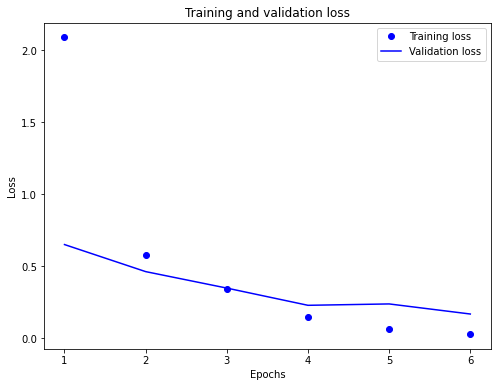

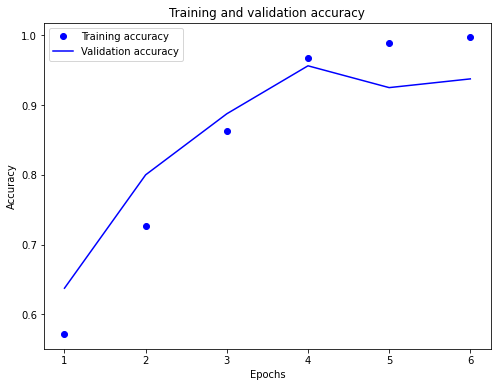

In [133]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [134]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
print(metrics.classification_report(Y_test, test_pred_class))

5/5 [==============================] - 2s 299ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       100
           1       0.95      0.88      0.91        60

    accuracy                           0.94       160
   macro avg       0.94      0.93      0.93       160
weighted avg       0.94      0.94      0.94       160



### essai bearing- 2D

In [136]:
df0 = df_bearing # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=500).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)
target1= df_use0['sound_type']

target = target1.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_selected["filepath"], target, test_size=0.2,
                                                              random_state=123)

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)
print(X_train.shape)
Y_train.shape

(640, 241, 334, 1)


(640,)

In [137]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#Compile


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), verbose=1, batch_size=32, epochs=6)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 239, 332, 32)      320       
                                                                 
 conv2d_24 (Conv2D)          (None, 237, 330, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 118, 165, 64)     0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 118, 165, 64)      0         
                                                                 
 flatten_10 (Flatten)        (None, 1246080)           0         
                                                                 
 dense_46 (Dense)            (None, 128)               159498368 
                                                     

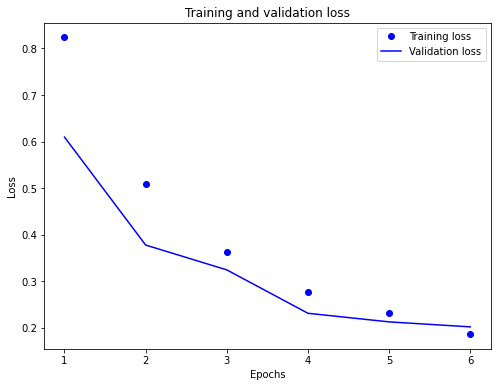

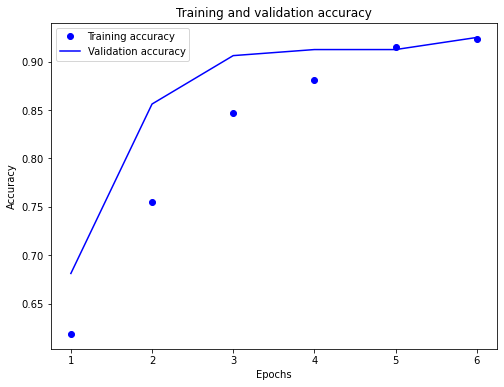

In [138]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [139]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
print(metrics.classification_report(Y_test, test_pred_class))

5/5 [==============================] - 2s 297ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       100
           1       0.89      0.92      0.90        60

    accuracy                           0.93       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.93      0.93      0.93       160



### essai fan- 2D

In [146]:
df0 = df_fan # to change for other machines

df1=df0[df0['sound_type']=='normal'].sample(n=500).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)
target1= df_use0['sound_type']

target = target1.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_selected["filepath"], target, test_size=0.2,
                                                              random_state=123)

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)
print(X_train.shape)
Y_train.shape

(640, 241, 334, 1)


(640,)

In [151]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), verbose=1, batch_size=32, epochs=16)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 239, 332, 32)      320       
                                                                 
 conv2d_28 (Conv2D)          (None, 237, 330, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 118, 165, 64)     0         
 g2D)                                                            
                                                                 
 dropout_76 (Dropout)        (None, 118, 165, 64)      0         
                                                                 
 flatten_12 (Flatten)        (None, 1246080)           0         
                                                                 
 dense_50 (Dense)            (None, 128)               159498368 
                                                     

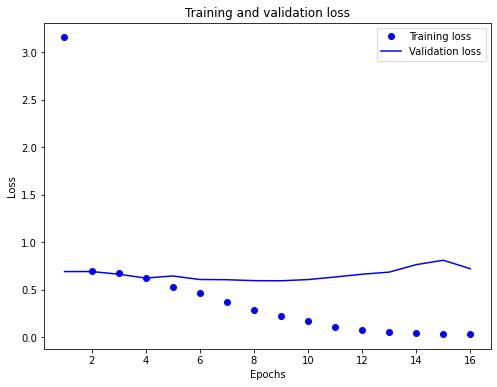

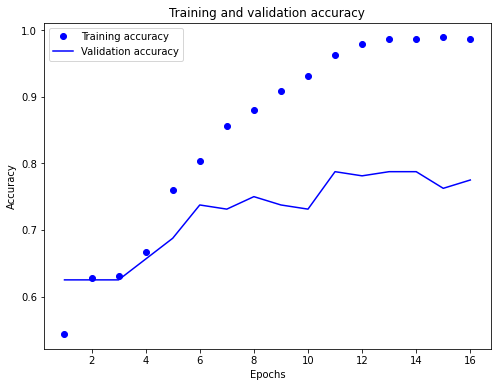

In [152]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [153]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
print(metrics.classification_report(Y_test, test_pred_class))

5/5 [==============================] - 2s 305ms/step
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       100
           1       0.77      0.57      0.65        60

    accuracy                           0.78       160
   macro avg       0.77      0.73      0.74       160
weighted avg       0.77      0.78      0.77       160



### Essai full - 2D

In [163]:

df0 = df_valve # to change for other machines

dfv=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2v=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0v= pd.concat([dfv,df2v]).reset_index()
df_use0v= df_use0v.drop('level_0', axis = 1)
df_selectedv= df_use0v.drop('index', axis = 1)

df_selectedv = df_selectedv.replace(to_replace = ['normal', 'anomaly'], value = [1, 0])


df0 = df_bearing # to change for other machines

df1b=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2b=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0b= pd.concat([df1b,df2b]).reset_index()
df_use0b= df_use0b.drop('level_0', axis = 1)
df_selectedb= df_use0b.drop('index', axis = 1)

df_selectedb = df_selectedb.replace(to_replace = ['normal', 'anomaly'], value = [2, 0])


df0 = df_fan # to change for other machines

df1f=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2f=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0f= pd.concat([df1f,df2f]).reset_index()
df_use0f= df_use0f.drop('level_0', axis = 1)
df_selectedf= df_use0f.drop('index', axis = 1)

df_selectedf = df_selectedf.replace(to_replace = ['normal', 'anomaly'], value = [3, 0])

df0 = df_slider # to change for other machines

df1s=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2s=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0s= pd.concat([df1s,df2s]).reset_index()
df_use0s= df_use0s.drop('level_0', axis = 1)
df_selecteds= df_use0s.drop('index', axis = 1)

df_selecteds = df_selecteds.replace(to_replace = ['normal', 'anomaly'], value = [4, 0])

df0 = df_car # to change for other machines

df1c=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2c=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0c= pd.concat([df1c,df2c]).reset_index()
df_use0c= df_use0c.drop('level_0', axis = 1)
df_selectedc= df_use0c.drop('index', axis = 1)

df_selectedc = df_selectedc.replace(to_replace = ['normal', 'anomaly'], value = [5, 0])

df0 = df_train # to change for other machines

df1t=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2t=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0t= pd.concat([df1t,df2t]).reset_index()
df_use0t= df_use0t.drop('level_0', axis = 1)
df_selectedt= df_use0t.drop('index', axis = 1)

df_selectedt = df_selectedt.replace(to_replace = ['normal', 'anomaly'], value = [6, 0])

df0 = df_gearbox

df1=df0[df0['sound_type']=='normal'].sample(n=600).reset_index()
df2=df0[df0['sound_type']=='anomaly'].sample(n=300).reset_index()
df_use0= pd.concat([df1,df2]).reset_index()
df_use0= df_use0.drop('level_0', axis = 1)
df_selected= df_use0.drop('index', axis = 1)

df_selected = df_selected.replace(to_replace = ['normal', 'anomaly'], value = [7, 0])


df_all= pd.concat([df_selected,df_selectedt,df_selectedc,df_selecteds,df_selectedf,df_selectedb,df_selectedv]).reset_index()
df_all= df_all.drop('index', axis = 1)
df_all.head(10)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    6300 non-null   object
 1   filename    6300 non-null   object
 2   section     6300 non-null   int64 
 3   domain_env  6300 non-null   object
 4   dir         6300 non-null   object
 5   sound_type  6300 non-null   int64 
 6   id          6300 non-null   object
 7   suffix      6300 non-null   object
dtypes: int64(2), object(6)
memory usage: 393.9+ KB


In [166]:
target= df_all['sound_type']
target.tail()

6295    0
6296    0
6297    0
6298    0
6299    0
Name: sound_type, dtype: int64

In [168]:
X_train_path, X_test_path, Y_train, Y_test = train_test_split(df_all["filepath"], target, test_size=0.2,
                                                              random_state=123)

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)
print(X_train.shape)

(5040, 241, 334, 1)


In [172]:
Y_train= to_categorical(Y_train)
Y_test= to_categorical(Y_test)

In [174]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
#Compile
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

model.summary()
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), verbose=1, batch_size=100, epochs=15)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 239, 332, 32)      320       
                                                                 
 conv2d_38 (Conv2D)          (None, 237, 330, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 118, 165, 64)     0         
 g2D)                                                            
                                                                 
 dropout_86 (Dropout)        (None, 118, 165, 64)      0         
                                                                 
 flatten_17 (Flatten)        (None, 1246080)           0         
                                                                 
 dense_60 (Dense)            (None, 128)               159498368 
                                                     

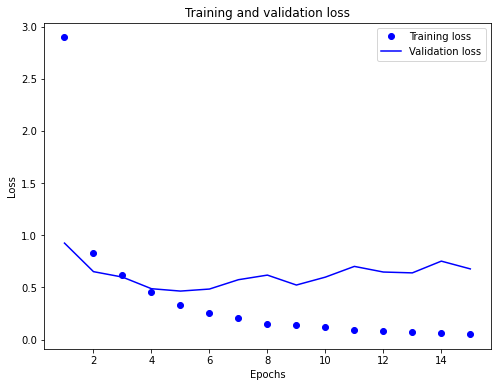

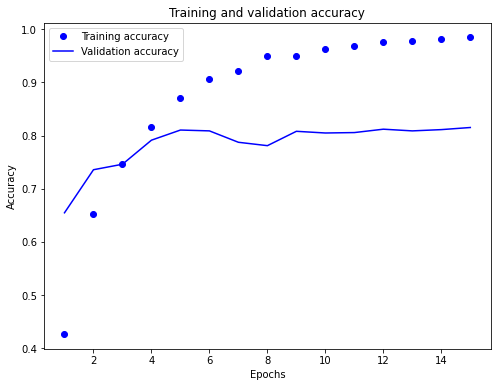

In [175]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot des courbes accuracy d'entrainement et de validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [177]:
test_pred_= model.predict(X_test)
test_pred_class= test_pred_.argmax(axis=1)
Y_test_class=Y_test.argmax(axis=1)
print(metrics.classification_report(Y_test_class, test_pred_class))

40/40 [==============================] - 12s 298ms/step
              precision    recall  f1-score   support

           0       0.78      0.63      0.69       417
           1       0.70      0.82      0.76       133
           2       0.96      0.98      0.97       109
           3       0.76      0.82      0.78       114
           4       0.96      0.97      0.96       127
           5       0.74      0.96      0.84       111
           6       0.87      0.91      0.89       129
           7       0.86      0.91      0.88       120

    accuracy                           0.82      1260
   macro avg       0.83      0.87      0.85      1260
weighted avg       0.82      0.82      0.81      1260



In [178]:
print(pd.crosstab(Y_test_class, test_pred_class))

col_0    0    1    2   3    4    5    6    7
row_0                                       
0      261   46    4  29    4   38   18   17
1       24  109    0   0    0    0    0    0
2        2    0  107   0    0    0    0    0
3       19    0    0  93    1    0    0    1
4        3    0    0   1  123    0    0    0
5        4    0    0   0    0  107    0    0
6       11    0    0   0    0    0  118    0
7       11    0    0   0    0    0    0  109
